# Analyzing airport features and predicting passenger numbers

## Step 1: Load Data

### Importing necessary packages

For a better overview and to prevent redundancy, all import statements required throughout the notebook are pooled here:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns
import psycopg2
import pandas.io.sql as sqlio
from sqlalchemy import create_engine
import geopandas
import geodatasets

### Importing data from the PostgreSQL database

In [2]:
# PostgreSQL connection and queries with psycopg2

# Connect to Postgres database
conn = psycopg2.connect("dbname=ENTER_DB user=ENTER_USER password=ENTER_PW")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
query = "SELECT * FROM airports A JOIN airports_annex AA ON A.code = AA.code;"
cur.execute(query)

# Retrieve query results
cur.fetchall()

[(67,
  'AYPY',
  'Large',
  'Port Moresby Jacksons International Airport',
  -9.443380355834961,
  147.22000122070312,
  146,
  'OC',
  'PG',
  'PG-NCD',
  'Port Moresby',
  True,
  'AYPY',
  'POM',
  None,
  None,
  'https://en.wikipedia.org/wiki/Jacksons_International_Airport',
  None,
  'POM',
  1400000),
 (113,
  'BGBW',
  'Medium',
  'Narsarsuaq Airport',
  61.1604995728,
  -45.4259986877,
  112,
  'NA',
  'GL',
  'GL-U-A',
  'Narsarsuaq',
  True,
  'BGBW',
  'UAK',
  None,
  None,
  'https://en.wikipedia.org/wiki/Narsarsuaq_Airport',
  None,
  'UAK',
  26284),
 (31694,
  'BGJN',
  'Small',
  'Ilulissat Airport',
  69.2432022095,
  -51.0570983887,
  95,
  'NA',
  'GL',
  'GL-U-A',
  'Ilulissat',
  True,
  'BGJN',
  'JAV',
  None,
  None,
  'https://en.wikipedia.org/wiki/Ilulissat_Airport',
  None,
  'JAV',
  83930),
 (115,
  'BGSF',
  'Medium',
  'Kangerlussuaq Airport',
  67.0122218992,
  -50.7116031647,
  165,
  'NA',
  'GL',
  'GL-U-A',
  'Kangerlussuaq',
  True,
  'BGSF',
  '

In [3]:
# PostgreSQL connection and loading query results into pandas with sqlalchemy

# Connect to Postgres database
engine = create_engine("postgresql+psycopg2://USER:PW@localhost:5432/DB")

# Query database for all airports / airports with available passenger data
query_airports = "select * from airports;"
query_airports_annex = "select * from airports_annex;"

# Load the query results into pandas dataframes
df_airports = sqlio.read_sql_query(sql = query_airports, con = engine)
df_airports_annex = sqlio.read_sql_query(sql = query_airports_annex, con = engine)

# Merge the dataframes to create one dataframe with all airports and one with only airports with passenger data
df_all = df_airports.merge(df_airports_annex, 'outer', 'code')
df_pax = df_airports.merge(df_airports_annex, 'inner', 'code')

In [4]:
# Query database for details on the runways of all airports
query_runways = """
SELECT
 A.code,
 COUNT(R.id) rwy_count,
 MAX(R.length_ft) rwy_len_max,
 MIN(R.length_ft) rwy_len_min,
 AVG(R.length_ft) rwy_len_avg,
 percentile_cont (0.50) WITHIN GROUP (ORDER BY R.length_ft) rwy_len_mid,
 COUNT(CASE WHEN R.length_ft >= 8000 THEN 1 ELSE NULL END) rwy_len_8000ft,
 COUNT(CASE WHEN R.length_ft >= 10000 THEN 1 ELSE NULL END) rwy_len_10000ft,
 COUNT(CASE WHEN R.length_ft >= 12000 THEN 1 ELSE NULL END) rwy_len_12000ft,
 MAX(R.width_ft) rwy_wid_max,
 MIN(R.width_ft) rwy_wid_min,
 AVG(R.width_ft) rwy_wid_avg,
 percentile_cont (0.50) WITHIN GROUP (ORDER BY R.width_ft) rwy_wid_mid,
 COUNT(CASE WHEN R.width_ft >= 100 THEN 1 ELSE NULL END) rwy_wid_100ft,
 COUNT(CASE WHEN R.width_ft >= 140 THEN 1 ELSE NULL END) rwy_wid_140ft,
 COUNT(CASE WHEN R.width_ft >= 180 THEN 1 ELSE NULL END) rwy_wid_180ft
FROM airports A
JOIN runways R ON A.ident = R.airport_ident
GROUP BY A.code
ORDER BY rwy_count DESC;
"""

# Load the query results into pandas dataframes
df_runways = sqlio.read_sql_query(sql = query_runways, con = engine)

# Merge the dataframes to create -) one dataframe with all airports PLUS runway data and -) one with only airports with passenger data PLUS runway data
df_all_rwy = df_all.merge(df_runways, 'inner', 'code')
df_pax_rwy = df_pax.merge(df_runways, 'inner', 'code')

## Step 2: Prepare and investigate the data

### Initial data preparation and cleaning

To tailor the comprehensive data at hand to the purpose of specifically analyzing commercial airports and predicting passenger numbers, the relevant data was modified on the database level. All individual commands are included in the SQL script <b>"data/db_data.sql"</b>. The main focus was to remove airports that are not suitable for or accessible to commercial airplanes, for example heliports, seaplane bases, military airports or airports with unpaved runways.

### Getting an overview of the dataset

Looking at the general properties of the dataset and its variables to get an idea of the available data (quality). For a better and more concise overview, we will mostly use the datasets without runway data below. First up is a glimpse of the first rows, the number of rows and columns as well as the column names, data types and number of non-null values:

In [5]:
df_pax.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent_code,country_code,region_code,municipality,scheduled_service,gps_code,code,local_code,home_link,wiki_link,keywords,pax_2018_or_older
0,67,AYPY,Large,Port Moresby Jacksons International Airport,-9.443380,147.220001,146.0,OC,PG,PG-NCD,Port Moresby,True,AYPY,POM,None,None,https://en.wikipedia.org/wiki/Jacksons_Interna...,None,1400000
1,113,BGBW,Medium,Narsarsuaq Airport,61.160500,-45.425999,112.0,NA,GL,GL-U-A,Narsarsuaq,True,BGBW,UAK,None,None,https://en.wikipedia.org/wiki/Narsarsuaq_Airport,None,26284
2,31694,BGJN,Small,Ilulissat Airport,69.243202,-51.057098,95.0,NA,GL,GL-U-A,Ilulissat,True,BGJN,JAV,None,None,https://en.wikipedia.org/wiki/Ilulissat_Airport,None,83930
3,115,BGSF,Medium,Kangerlussuaq Airport,67.012222,-50.711603,165.0,NA,GL,GL-U-A,Kangerlussuaq,True,BGSF,SFJ,None,None,https://en.wikipedia.org/wiki/Kangerlussuaq_Ai...,Sondre Stromfjord,133381
4,117,BIAR,Medium,Akureyri Airport,65.660004,-18.072701,6.0,EU,IS,IS-6,Akureyri,True,BIAR,AEY,None,None,https://en.wikipedia.org/wiki/Akureyri_Airport,None,202252


In [6]:
df_pax.shape

(1828, 19)

In [7]:
df_pax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1828 non-null   int64  
 1   ident              1828 non-null   object 
 2   type               1828 non-null   object 
 3   name               1828 non-null   object 
 4   latitude_deg       1828 non-null   float64
 5   longitude_deg      1828 non-null   float64
 6   elevation_ft       1824 non-null   float64
 7   continent_code     1828 non-null   object 
 8   country_code       1828 non-null   object 
 9   region_code        1828 non-null   object 
 10  municipality       1774 non-null   object 
 11  scheduled_service  1828 non-null   bool   
 12  gps_code           1828 non-null   object 
 13  code               1828 non-null   object 
 14  local_code         479 non-null    object 
 15  home_link          667 non-null    object 
 16  wiki_link          1787 

A better overview about the null values can be obtained other way around - displaying the number of null values per column:

In [8]:
df_pax.isnull().sum()

id                      0
ident                   0
type                    0
name                    0
latitude_deg            0
longitude_deg           0
elevation_ft            4
continent_code          0
country_code            0
region_code             0
municipality           54
scheduled_service       0
gps_code                0
code                    0
local_code           1349
home_link            1161
wiki_link              41
keywords             1212
pax_2018_or_older       0
dtype: int64

In [9]:
df_all = df_all.drop(columns = ["local_code", "home_link", "keywords"])
df_pax = df_pax.drop(columns = ["local_code", "home_link", "keywords"])

After dropping three columns with very high numbers of null values, the same overview looks like this:

In [10]:
df_pax.isnull().sum()

id                    0
ident                 0
type                  0
name                  0
latitude_deg          0
longitude_deg         0
elevation_ft          4
continent_code        0
country_code          0
region_code           0
municipality         54
scheduled_service     0
gps_code              0
code                  0
wiki_link            41
pax_2018_or_older     0
dtype: int64

I also checked if there are any completely duplicated rows (i.e. rows where the values are the same for all variables) - there are none.

In [11]:
df_all[df_all.duplicated() == True]

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent_code,country_code,region_code,municipality,scheduled_service,gps_code,code,wiki_link,pax_2018_or_older


The numeric variables can be further investigated using some descriptive statistics:

In [12]:
df_pax.describe()

,id,latitude_deg,longitude_deg,elevation_ft,pax_2018_or_older
count,1828.000000,1828.000000,1828.000000,1824.000000,1.828000e+03
mean,13276.184902,27.958311,4.718222,911.889803,4.628831e+06
std,35171.642644,25.295884,83.902158,1596.867320,1.146338e+07
min,67.000000,-54.843300,-176.199005,-65.000000,2.500000e+02
25%,3570.500000,13.944400,-76.042849,55.000000,2.048640e+05
50%,4740.000000,35.414850,10.505850,250.500000,6.953535e+05
75%,6504.250000,44.819926,73.902002,955.000000,2.821886e+06
max,333692.000000,78.246101,177.442993,13355.000000,1.073940e+08


In terms of data quality, there are no significant issues with columns mixing variables or containing multiple variables in one column. There are also no complete duplicate rows. Some variables have mostly Null values, especially the local_code, home_link and keywords variables.

### Visualizing individual variables

Below are descriptions of the variables and basic visualizations to get a feeling for the values of some of the numeric variables.

#### id
The database ID of each airport.

#### ident
For most airports, the airport's ICAO code.

#### type
The size of each airport: small, medium or large.

In [13]:
all_type_counts = df_all["type"].value_counts(sort = False).sort_index(ascending = False)
all_type_counts

type
Small     2045
Medium    3356
Large      563
Name: count, dtype: int64

In [14]:
pax_type_counts = df_pax["type"].value_counts(sort = False).sort_index(ascending = False)
pax_type_counts

type
Small       82
Medium    1206
Large      540
Name: count, dtype: int64

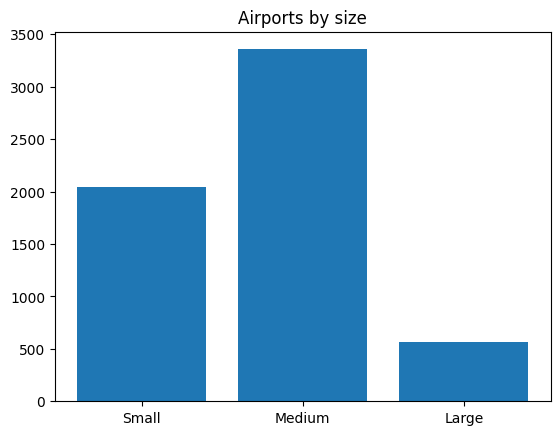

In [15]:
fig, ax = plt.subplots()
ax.bar(all_type_counts.index, all_type_counts)
ax.set_title("Airports by size")
plt.show()

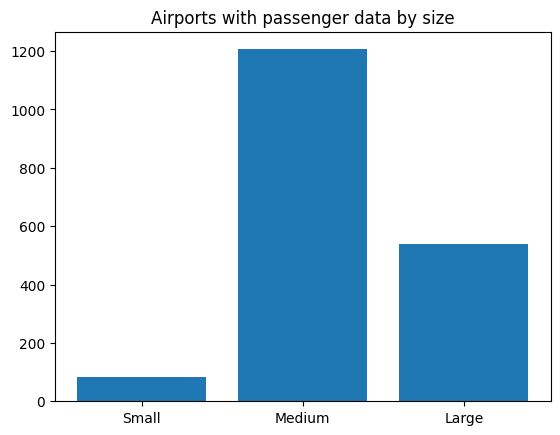

In [16]:
fig, ax = plt.subplots()
ax.bar(pax_type_counts.index, pax_type_counts)
ax.set_title("Airports with passenger data by size")
plt.show()

Medium-sized airports are by far the most frequent type of airport among those with passenger numbers in the database.

#### name
The name of each airport.

#### latitude_deg
The airport's latitude in degrees.

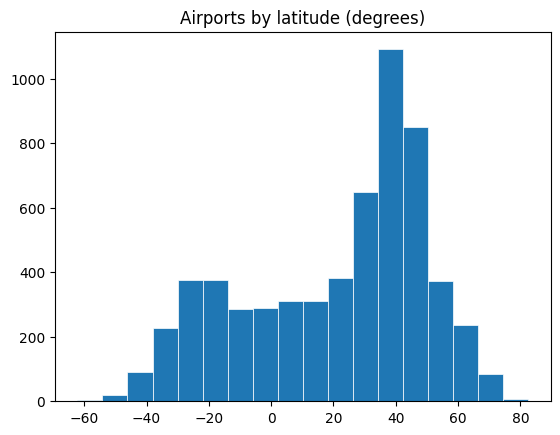

In [17]:
fig, ax = plt.subplots()
ax.hist(df_all["latitude_deg"], bins = 18, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports by latitude (degrees)")
plt.show()

#### longitude_deg
The airport's longitude in degrees.

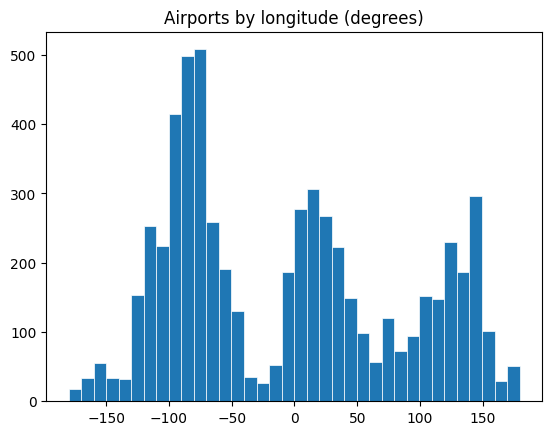

In [18]:
fig, ax = plt.subplots()
ax.hist(df_all["longitude_deg"], bins = 36, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports by longitude (degrees)")
plt.show()

The latitude and longitude charts nicely show the vast number of airports in North America and Europe as well as the regional lack of airports caused by the world's oceans. However, using the coordinates, we can visualize the airports even better - on a world map.

In [19]:
gdf_all = geopandas.GeoDataFrame(df_all, geometry = geopandas.points_from_xy(df_all.longitude_deg, df_all.latitude_deg), crs = "EPSG:4326")
gdf_pax = geopandas.GeoDataFrame(df_pax, geometry = geopandas.points_from_xy(df_pax.longitude_deg, df_pax.latitude_deg), crs = "EPSG:4326")
world = geopandas.read_file(geodatasets.get_path("naturalearth.land"))

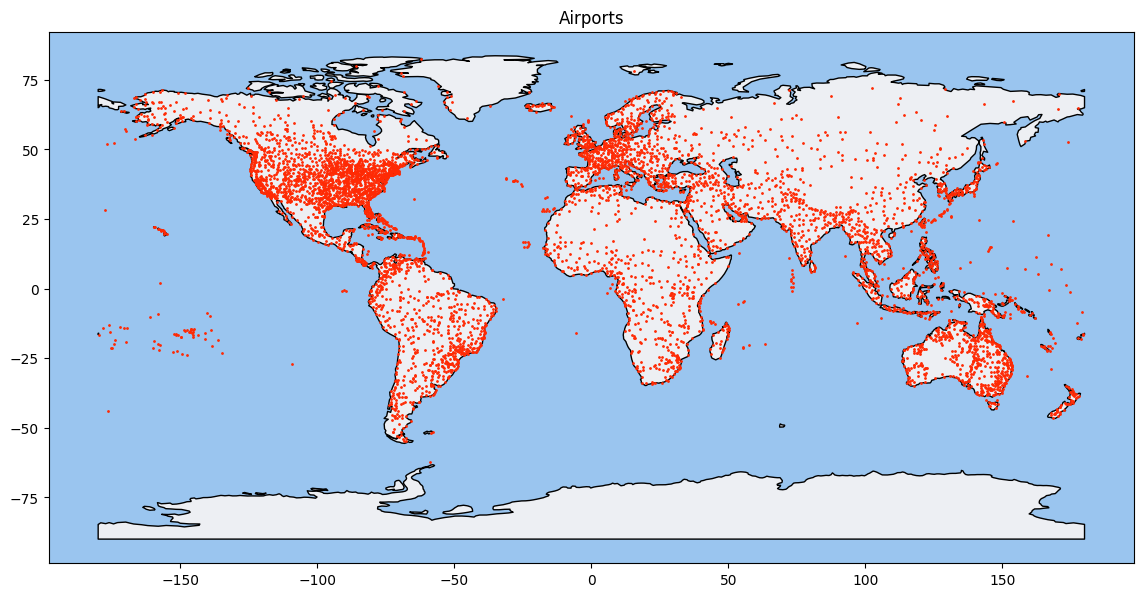

In [20]:
ax = world.plot(figsize = (14, 7), color = "#EDEFF3", edgecolor = "black")
ax.set_facecolor("#9AC5EF")
ax.set_title("Airports")
gdf_all.plot(ax = ax, color = "#FF2A04", markersize = 1)
plt.show()

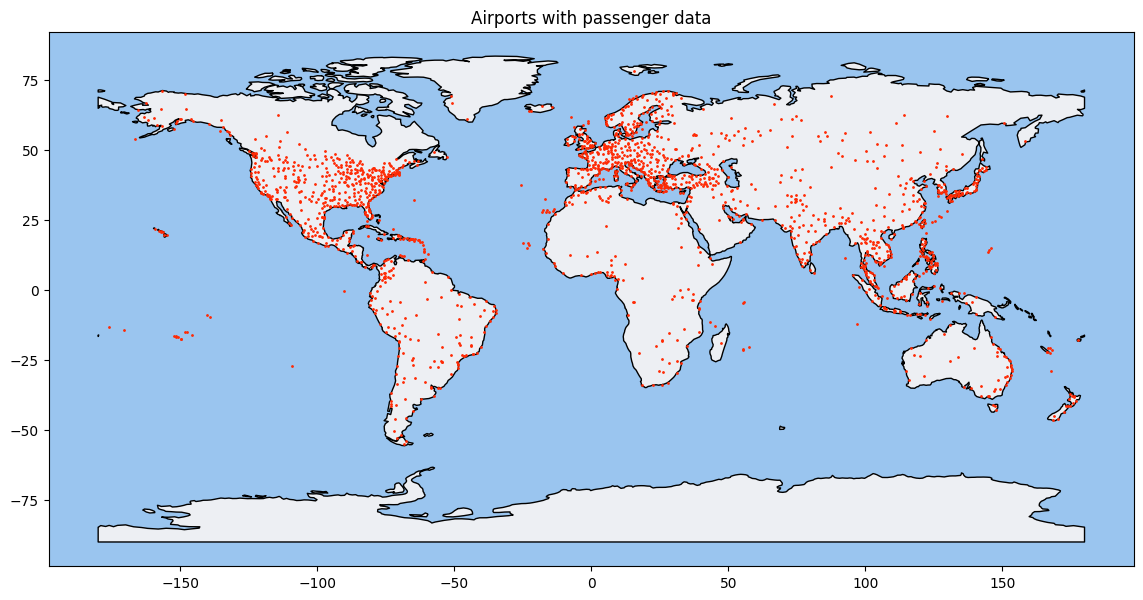

In [21]:
ax = world.plot(figsize = (14, 7), color = "#EDEFF3", edgecolor = "black")
ax.set_facecolor("#9AC5EF")
ax.set_title("Airports with passenger data")
gdf_pax.plot(ax = ax, color = "#FF2A04", markersize = 1)
plt.show()

#### elevation_ft
The elevation of each airport in feet.

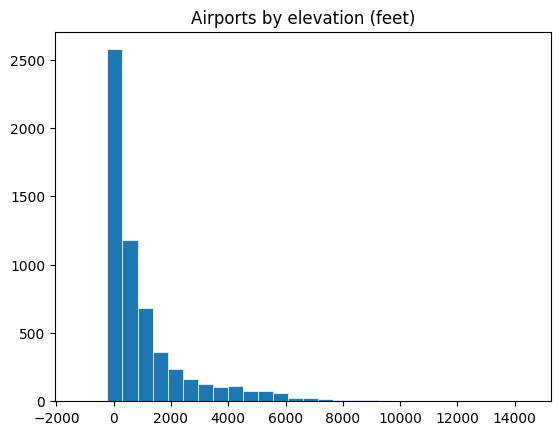

In [22]:
fig, ax = plt.subplots()
ax.hist(df_all["elevation_ft"], bins = 30, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports by elevation (feet)")
plt.show()

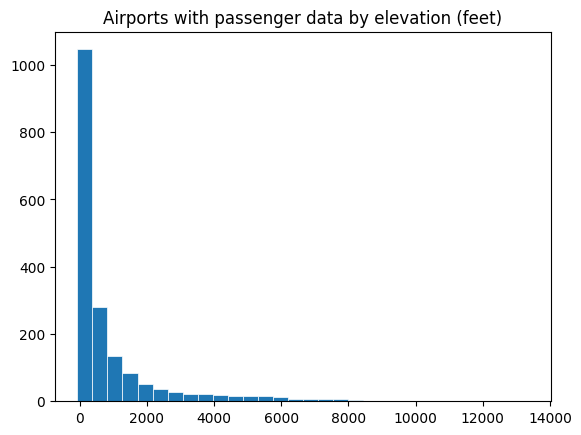

In [23]:
fig, ax = plt.subplots()
ax.hist(df_pax["elevation_ft"], bins = 30, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports with passenger data by elevation (feet)")
plt.show()

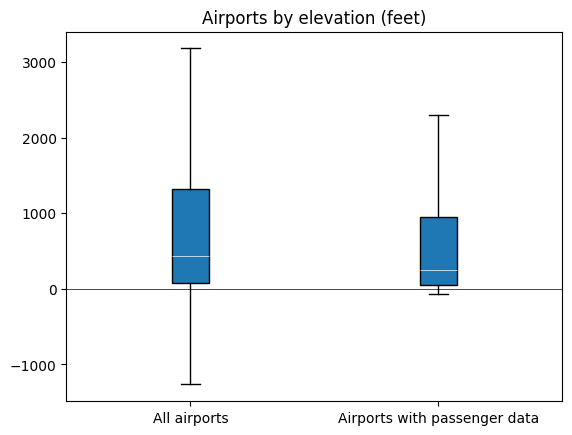

In [24]:
elevation_all = df_all["elevation_ft"].dropna()
elevation_pax = df_pax["elevation_ft"].dropna()
fig, ax = plt.subplots()
ax.boxplot([elevation_all, elevation_pax], patch_artist = True, showfliers = False, positions = [0, 1], medianprops = {"color": "white", "linewidth": 0.5}, labels = ["All airports", "Airports with passenger data"])
ax.set_title("Airports by elevation (feet)")
ax.axhline(0, color = "black", linewidth = 0.5)
plt.show()

Both the histograms and the boxplots show that some airports are below sea level and that most airports have an elevation between 0 and 2500 feet. The plots also indicate that airports with passenger data have fewer highly positive elevations and fewer negative elevations.

#### continent_code
The continent on which the airport is located. The SQL query below retrieves all continent codes and corresponding names from the database.

In [25]:
# Query database for continent codes and names
query_continents = "select * from continents;"

# Show the query results
sqlio.read_sql_query(sql = query_continents, con = engine)

,code,name
0,AF,Africa
1,AN,Antarctica
2,AS,Asia
3,EU,Europe
4,NA,North America
5,OC,Oceania
6,SA,South America


In [26]:
all_continent_counts = df_all["continent_code"].value_counts(sort = False).sort_index(ascending = True)
all_continent_counts

continent_code
AF     561
AN       1
AS    1097
EU     815
NA    2104
OC     706
SA     680
Name: count, dtype: int64

In [27]:
pax_continent_counts = df_pax["continent_code"].value_counts(sort = False).sort_index(ascending = True)
pax_continent_counts

continent_code
AF    121
AS    503
EU    473
NA    507
OC     85
SA    139
Name: count, dtype: int64

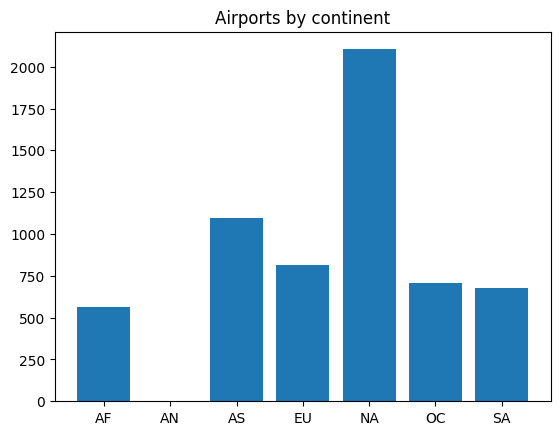

In [28]:
fig, ax = plt.subplots()
ax.bar(all_continent_counts.index, all_continent_counts)
ax.set_title("Airports by continent")
plt.show()

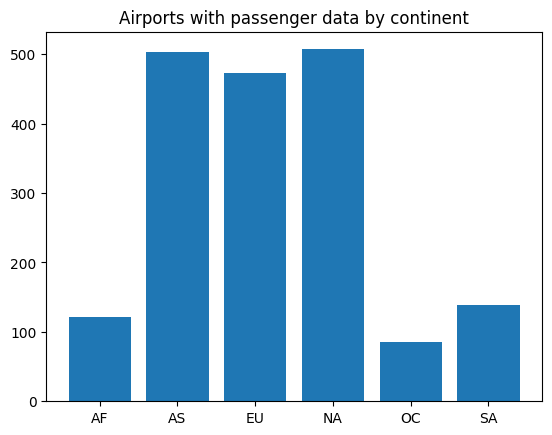

In [29]:
fig, ax = plt.subplots()
ax.bar(pax_continent_counts.index, pax_continent_counts)
ax.set_title("Airports with passenger data by continent")
plt.show()

North America has the most airports by far, while the number of airports with passenger data is very similar in Asia, Europe and North America.

#### country_code
The country in which the airport is located. The SQL query below retrieves all country codes and corresponding names from the database.

In [30]:
# Query database for continent codes and names
query_countries = "select * from countries;"

# Show the query results
sqlio.read_sql_query(sql = query_countries, con = engine)

,id,code,name,continent,wiki_link,keywords
0,302672,AD,Andorra,EU,https://en.wikipedia.org/wiki/Andorra,None
1,302618,AE,United Arab Emirates,AS,https://en.wikipedia.org/wiki/United_Arab_Emir...,"UAE,مطارات في الإمارات العربية المتحدة"
2,302619,AF,Afghanistan,AS,https://en.wikipedia.org/wiki/Afghanistan,None
3,302722,AG,Antigua and Barbuda,NA,https://en.wikipedia.org/wiki/Antigua_and_Barbuda,None
4,302723,AI,Anguilla,NA,https://en.wikipedia.org/wiki/Anguilla,None
...,...,...,...,...,...,...
242,302609,YT,Mayotte,AF,https://en.wikipedia.org/wiki/Mayotte,None
243,302610,ZA,South Africa,AF,https://en.wikipedia.org/wiki/South_Africa,None
244,302611,ZM,Zambia,AF,https://en.wikipedia.org/wiki/Zambia,None
245,302612,ZW,Zimbabwe,AF,https://en.wikipedia.org/wiki/Zimbabwe,None


In [31]:
all_top_20_country_counts = df_all["country_code"].value_counts(sort = True)[0:20]
all_top_20_country_counts

country_code
US    1514
AU     506
CA     316
BR     306
ID     136
IN     120
FR     114
AR      99
RU      98
CN      97
JP      92
MX      82
DE      70
IR      69
CO      68
ZA      63
GB      62
PH      56
PG      55
TR      55
Name: count, dtype: int64

In [32]:
pax_top_20_country_counts = df_pax["country_code"].value_counts(sort = True)[0:20]
pax_top_20_country_counts

country_code
US    368
RU     66
IN     56
JP     52
FR     51
MX     51
CN     51
ID     50
BR     48
TR     47
AU     46
NO     43
PH     40
GR     39
GB     34
ES     33
TH     33
CA     31
IT     31
SE     28
Name: count, dtype: int64

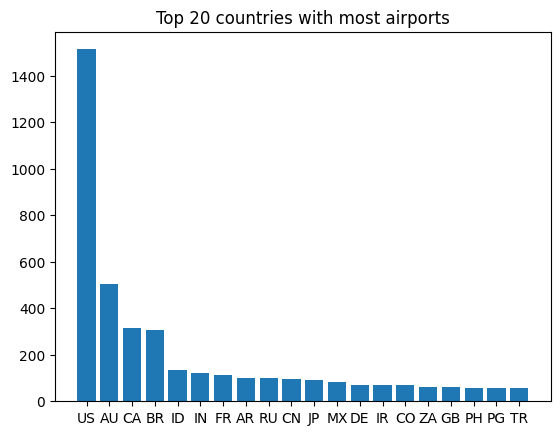

In [33]:
fig, ax = plt.subplots()
ax.bar(all_top_20_country_counts.index, all_top_20_country_counts)
ax.set_title("Top 20 countries with most airports")
plt.show()

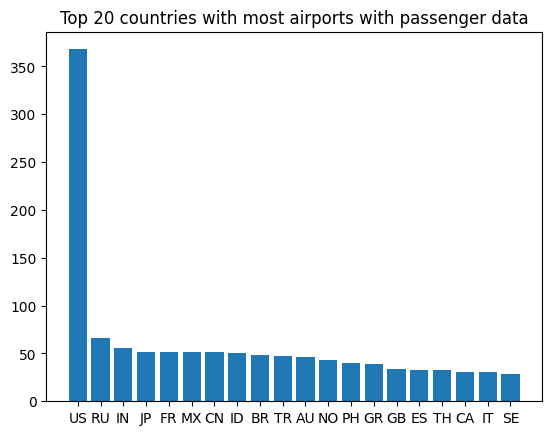

In [34]:
fig, ax = plt.subplots()
ax.bar(pax_top_20_country_counts.index, pax_top_20_country_counts)
ax.set_title("Top 20 countries with most airports with passenger data")
plt.show()

The United States have by far the most airports of any country, both in total and in terms of airports with passenger data. Australia and Canada have the second and third highest total numbers while Russia and India have the second and third highest numbers of airports with passenger data.

#### region_code

The region within a country in which an airport is located.

In [35]:
all_top_20_region_counts = df_all["region_code"].value_counts(sort = True)[0:20]
all_top_20_region_counts

region_code
AU-QLD    170
US-CA     119
AU-WA     103
US-TX      99
US-AK      88
AU-NSW     75
AU-NT      66
US-FL      63
CA-ON      59
CA-BC      52
AU-SA      50
CA-QC      50
US-MI      45
US-AZ      42
US-WI      42
US-IA      41
US-PA      40
US-NY      39
US-IL      37
US-CO      36
Name: count, dtype: int64

In [36]:
pax_top_20_region_counts = df_pax["region_code"].value_counts(sort = True)[0:20]
pax_top_20_region_counts

region_code
US-CA     25
US-AK     25
US-TX     24
GB-ENG    21
US-FL     20
AU-QLD    15
US-NY     15
US-MI     15
US-IL     11
PF-U-A    11
US-WA     11
NO-20     10
AU-NSW    10
NO-18     10
GB-SCT     9
US-NC      9
US-PA      9
US-CO      9
US-OH      9
FR-NAQ     9
Name: count, dtype: int64

In [37]:
query_regions = "select * from regions where code = 'AU-QLD' OR code = 'US-CA' OR code = 'US-AK';"
sqlio.read_sql_query(sql = query_regions, con = engine)

,id,code,local_code,name,continent,country,wiki_link,keywords
0,302971,AU-QLD,QLD,Queensland,OC,AU,https://en.wikipedia.org/wiki/Queensland,None
1,306076,US-AK,AK,Alaska,NA,US,https://en.wikipedia.org/wiki/Alaska,None
2,306080,US-CA,CA,California,NA,US,https://en.wikipedia.org/wiki/California,None


The region with most total airports is Queensland, Australia. In terms of most airports with passenger data, two regions share first place: California, USA and Alaska, USA.

#### municipality

The municipality in which the airport is located. In contrast to previous attributes, there is no code and no foreign key relationship to a separate table containing more details, instead values of this attribute contain municipality names as a string.

In [38]:
all_top_20_municipality_counts = df_all["municipality"].value_counts(sort = True)[0:20]
all_top_20_municipality_counts

municipality
London          7
Houston         7
Greenville      7
San Jose        6
Columbus        6
Jackson         5
Paris           5
Hamilton        5
Rome            5
Jacksonville    5
Melbourne       5
Georgetown      4
Washington      4
Toledo          4
Columbia        4
Santiago        4
Clinton         4
Trinidad        4
Moscow          4
Portland        4
Name: count, dtype: int64

In [39]:
query_regions = "select * from airports where municipality = 'London';"
sqlio.read_sql_query(sql = query_regions, con = engine)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent_code,country_code,region_code,municipality,scheduled_service,gps_code,code,local_code,home_link,wiki_link,keywords
0,2419,EGGW,Large,London Luton Airport,51.874699,-0.368333,526,EU,GB,GB-ENG,London,True,EGGW,LTN,None,http://www.london-luton.co.uk/en/,https://en.wikipedia.org/wiki/London_Luton_Air...,LON
1,2430,EGLC,Medium,London City Airport,51.505299,0.055278,19,EU,GB,GB-ENG,London,True,EGLC,LCY,None,http://www.londoncityairport.com/,https://en.wikipedia.org/wiki/London_City_Airport,LON
2,2429,EGKK,Large,London Gatwick Airport,51.148102,-0.190278,202,EU,GB,GB-ENG,London,True,EGKK,LGW,None,http://www.gatwickairport.com/,https://en.wikipedia.org/wiki/Gatwick_Airport,"LON, Crawley, Charlwood"
3,2434,EGLL,Large,London Heathrow Airport,51.470600,-0.461941,83,EU,GB,GB-ENG,London,True,EGLL,LHR,None,http://www.heathrowairport.com/,https://en.wikipedia.org/wiki/Heathrow_Airport,"LON, Londres"
4,2476,EGSS,Large,London Stansted Airport,51.884998,0.235000,348,EU,GB,GB-ENG,London,True,EGSS,STN,None,http://www.stanstedairport.com/,https://en.wikipedia.org/wiki/London_Stansted_...,LON
5,3650,KLOZ,Medium,London-Corbin Airport/Magee Field,37.082199,-84.084900,1212,NA,US,US-KY,London,False,KLOZ,LOZ,LOZ,http://www.london-corbinairport.com/,https://en.wikipedia.org/wiki/London-Corbin_Ai...,None
6,1968,CYXU,Medium,London Airport,43.035599,-81.153900,912,NA,CA,CA-ON,London,True,CYXU,YXU,None,http://www.londonairport.on.ca/,https://en.wikipedia.org/wiki/London_Internati...,None


When looking up the 7 airports in the top-listed municipality "London", the effects of the lack of a unique code mentioned above are immediately visible: only 5 of the 7 airports are located in London, GB while the others are in London, Ontario in Canada and London, Kentucky in the United States, respectively. This must be kept in mind when performing statistical analysis or any further operations using this attribute.

#### scheduled_service

Whether the airport sees any regularly scheduled flights.

In [40]:
all_service_counts = df_all["scheduled_service"].value_counts(sort = False).sort_index(ascending = False)
all_service_counts

scheduled_service
True     3196
False    2768
Name: count, dtype: int64

In [41]:
pax_service_counts = df_pax["scheduled_service"].value_counts(sort = False).sort_index(ascending = False)
pax_service_counts

scheduled_service
True     1744
False      84
Name: count, dtype: int64

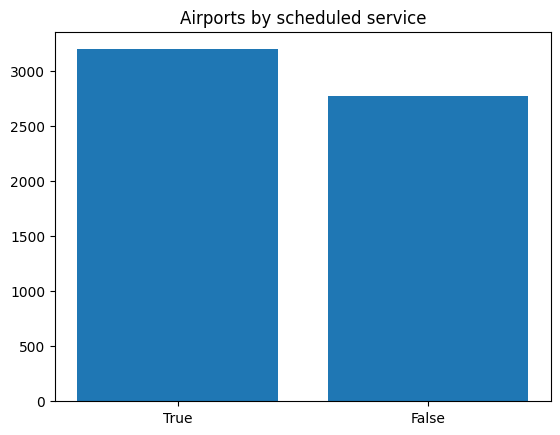

In [42]:
fig, ax = plt.subplots()
ax.bar(["True", "False"], all_service_counts)
ax.set_title("Airports by scheduled service")
plt.show()

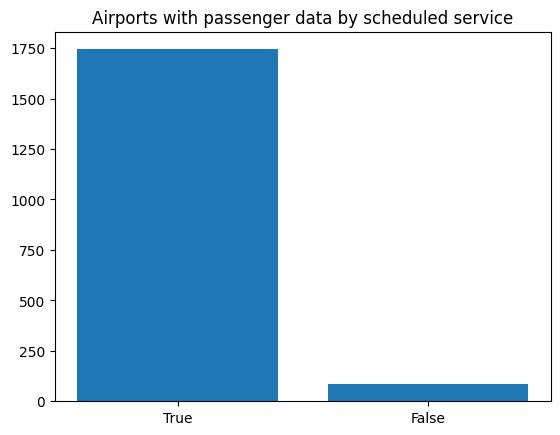

In [43]:
fig, ax = plt.subplots()
ax.bar(["True", "False"], pax_service_counts)
ax.set_title("Airports with passenger data by scheduled service")
plt.show()

As the airport data and the passenger data are from different sources, analyzing the values of this attribute is useful for evaluating the fit of these two datasets. Above, we can see that 95.4 percent of airports with passenger data are categorized as airports with scheduled service in the airport data. A high overlap here intuitively makes sense and is to be expected as typically, only airports with scheduled service will report passenger numbers or be significant enough for their reported passenger numbers to be featured on Wikipedia (passenger data source). However, we can also see that our passenger data only covers just over half of all airports with scheduled service.

#### gps_code

GPS code for navigation purposes, just like for "ident", this is often the airport's ICAO code.

#### code

The airport's IATA code.

#### wiki_link

URL to the airport's Wikipedia page. Values for this attribute are selected according to this priority list:
1) English Wikipedia page, if available.
2) Wikipedia page in another language, if available.
3) Null

#### pax_2018_or_older

Total yearly passenger number of the airport. These values were originally taken from Wikipedia and either refer to 2018 or the latest year with available data before 2018.

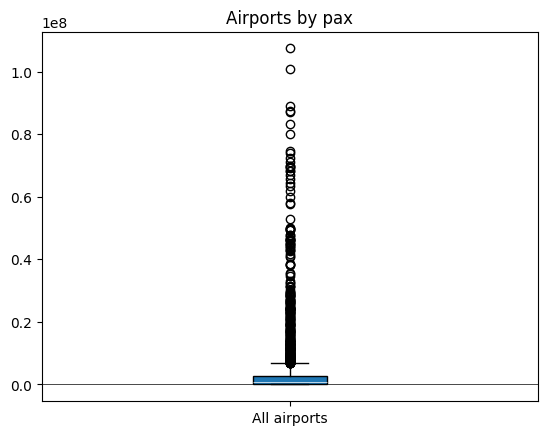

In [44]:
pax = df_pax["pax_2018_or_older"].dropna()
fig, ax = plt.subplots()
ax.boxplot(pax, patch_artist = True, showfliers = True,  medianprops = {"color": "white", "linewidth": 0.5}, labels = ["All airports"])
ax.set_title("Airports by pax")
ax.axhline(0, color = "black", linewidth = 0.5)
plt.show()

#### rwy_count

The number of runways an airport has.

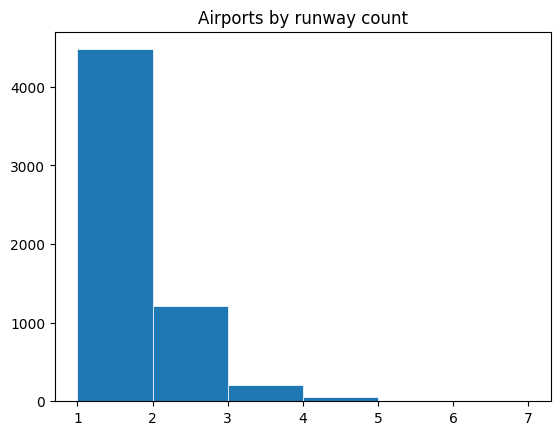

In [45]:
fig, ax = plt.subplots()
ax.hist(df_all_rwy["rwy_count"], bins = 6, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports by runway count")
plt.show()

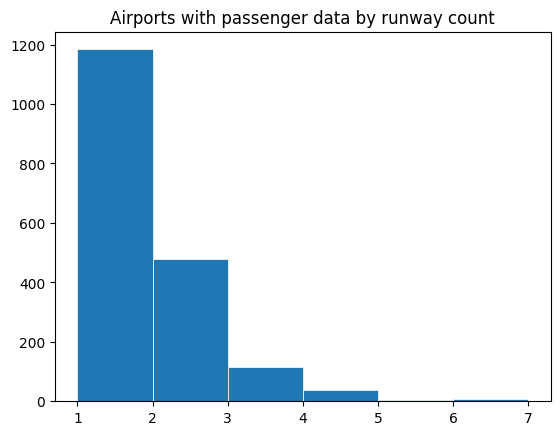

In [46]:
fig, ax = plt.subplots()
ax.hist(df_pax_rwy["rwy_count"], bins = 6, linewidth = 0.5, edgecolor = "white")
ax.set_title("Airports with passenger data by runway count")
plt.show()

#### rwy_len_*

rwy_len_max: Length of an airport's longest runway in feet. <br>
rwy_len_min: Length of an airport's shortest runway in feet. <br>
rwy_len_avg: Average length of an airport's runways in feet. <br>
rwy_len_mid: Median length of an airport's runways in feet. <br>
rwy_len_8000ft: Count of an airport's runways at least 8000ft long. <br>
rwy_len_10000ft: Count of an airport's runways at least 10000ft long. <br>
rwy_len_12000ft: Count of an airport's runways at least 12000ft long. <br>

#### rwy_wid_*

rwy_wid_max: Width of an airport's widest runway in feet. <br>
rwy_wid_min: Width of an airport's narrowest runway in feet. <br>
rwy_wid_avg: Average width of an airport's runways in feet. <br>
rwy_wid_mid: Median width of an airport's runways in feet. <br>
rwy_wid_100ft: Count of an airport's runways at least 100 feet wide. <br>
rwy_wid_140ft: Count of an airport's runways at least 140 feet wide. <br>
rwy_wid_180ft: Count of an airport's runways at least 180 feet wide. <br>

## Step 3: Build clusters of airports

### Clustering passenger numbers and elevation

Underlying hypothesis: airports with lower elevation (= better engine performance and lower operating costs) have larger passenger numbers.

current number of clusters:  2
calculating Davies-Bouldin score
current number of clusters:  3
calculating Davies-Bouldin score
current number of clusters:  4
calculating Davies-Bouldin score
current number of clusters:  5
calculating Davies-Bouldin score
current number of clusters:  6
calculating Davies-Bouldin score
current number of clusters:  7
calculating Davies-Bouldin score
current number of clusters:  8
calculating Davies-Bouldin score
current number of clusters:  9
calculating Davies-Bouldin score


[0.4389752443321689,
 0.474867586934484,
 0.44116564967672206,
 0.4437588103479616,
 0.43986178798700043,
 0.4539892840564102,
 0.47287899638722347,
 0.4808379328781154]

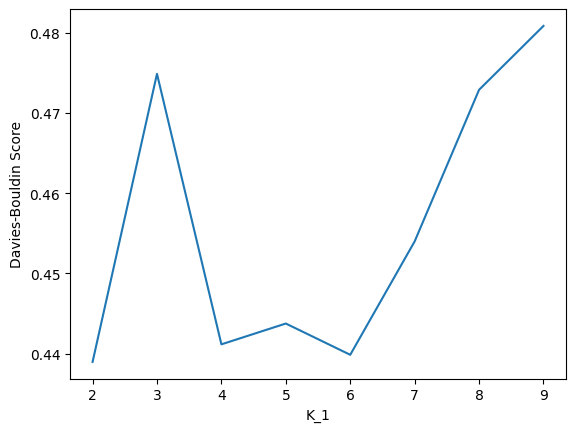

In [47]:
cluster_1 = df_pax.dropna(subset =["elevation_ft", "pax_2018_or_older"]).reset_index()
X_1 = cluster_1[["elevation_ft", "pax_2018_or_older"]].values

db_scores_1 = []
K_1 = range(2,10)

for k in K_1:
    print("current number of clusters: ", k)
    kmeans_preds = KMeans(n_clusters = k, n_init = 10).fit_predict(X_1)
    print("calculating Davies-Bouldin score")
    db_scores_1.append(davies_bouldin_score(X_1, kmeans_preds))

db_scores_frame_1 = pd.DataFrame({"K_1":K_1, "Davies-Bouldin Score": db_scores_1})
sns.lineplot(data=db_scores_frame_1, x="K_1", y="Davies-Bouldin Score")
db_scores_1

It is recommended to choose the number of clusters with the lowest DB-score and that was 2, closely followed by 6. When executing the code above multiple times, the results differ slightly from run to run.

<Axes: xlabel='elevation_ft', ylabel='pax_2018_or_older'>

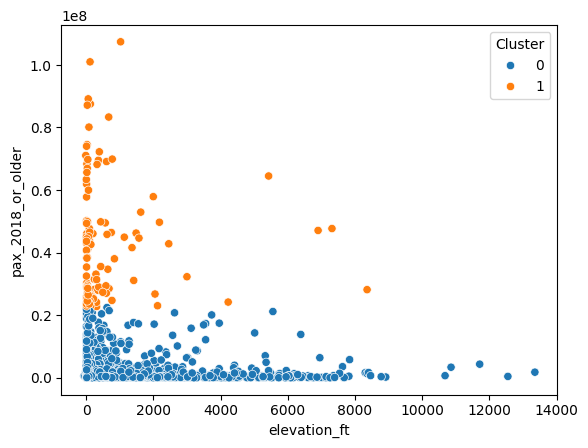

In [48]:
kmeans = KMeans(n_clusters = 2, n_init = 10, random_state = 1).fit(X_1)

plot_data = df_pax[["elevation_ft", "pax_2018_or_older"]].dropna()
plot_data["Cluster"] = kmeans.labels_

sns.scatterplot(data=plot_data, x="elevation_ft", y="pax_2018_or_older", hue="Cluster")

<Axes: xlabel='elevation_ft', ylabel='pax_2018_or_older'>

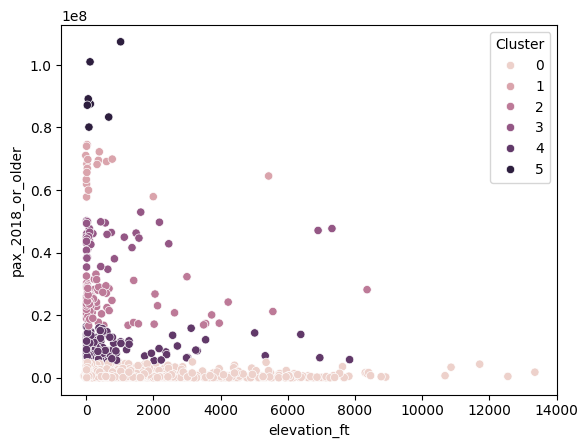

In [49]:
kmeans = KMeans(n_clusters = 6, n_init = 10, random_state = 1).fit(X_1)

plot_data = df_pax[["elevation_ft", "pax_2018_or_older"]].dropna()
plot_data["Cluster"] = kmeans.labels_

sns.scatterplot(data=plot_data, x="elevation_ft", y="pax_2018_or_older", hue="Cluster")

Both when using 2 and 6 clusters, the data seems to be clustered mostly into multiple levels of passenger numbers, each containing the full range of elevations observable in the graph. Therefore, the elevation does not seem to play any major role for clustering. Despite this result, the graphs clearly show a reduction in number and extent of high elevations / outliers with increasing passenger numbers. This calls for a regression later!

### Clustering latitude and longitude

I also wanted to see if it is possible to recreate a world map based on the scatterplot of the airports' coordinates and if the clusters potentially align with significant geographical features (e.g. continents) or administrative borders (e.g. countries).

current number of clusters:  2
calculating Davies-Bouldin score
current number of clusters:  3
calculating Davies-Bouldin score
current number of clusters:  4
calculating Davies-Bouldin score
current number of clusters:  5
calculating Davies-Bouldin score
current number of clusters:  6
calculating Davies-Bouldin score
current number of clusters:  7
calculating Davies-Bouldin score
current number of clusters:  8
calculating Davies-Bouldin score
current number of clusters:  9
calculating Davies-Bouldin score


[0.5700205680476458,
 0.5064187524852399,
 0.6413622644512182,
 0.667969849070357,
 0.7792664708731204,
 0.7833649239771766,
 0.7352021521069853,
 0.7599101912761218]

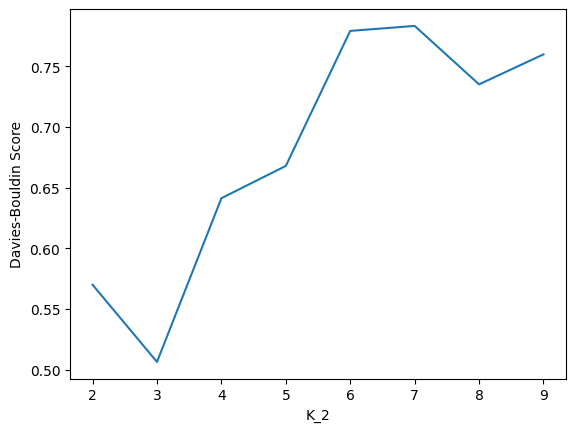

In [50]:
cluster_2 = df_pax.dropna(subset =["latitude_deg", "longitude_deg"]).reset_index()
X_2 = cluster_2[["latitude_deg", "longitude_deg"]].values

db_scores_2 = []
K_2 = range(2,10)

for k in K_2:
    print("current number of clusters: ", k)
    kmeans_preds = KMeans(n_clusters = k, n_init = 10).fit_predict(X_2)
    print("calculating Davies-Bouldin score")
    db_scores_2.append(davies_bouldin_score(X_2, kmeans_preds))

db_scores_frame_2 = pd.DataFrame({"K_2":K_2, "Davies-Bouldin Score": db_scores_2})
sns.lineplot(data=db_scores_frame_2, x="K_2", y="Davies-Bouldin Score")
db_scores_2

The score is lowest for 3 clusters, so let's try it out.

<Axes: xlabel='longitude_deg', ylabel='latitude_deg'>

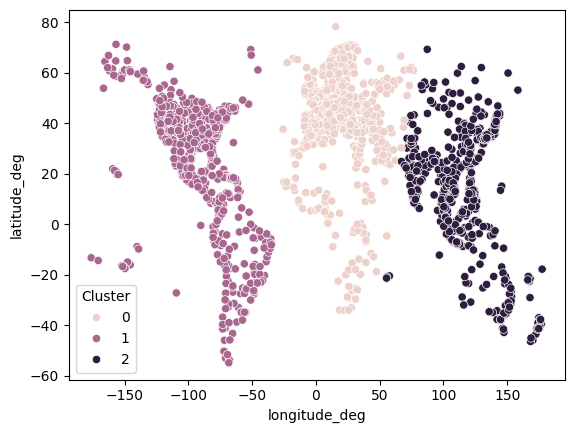

In [51]:
kmeans = KMeans(n_clusters = 3, n_init = 10, random_state = 1).fit(X_2)

plot_data = df_pax[["longitude_deg", "latitude_deg"]].dropna()
plot_data["Cluster"] = kmeans.labels_

sns.scatterplot(data=plot_data, x="longitude_deg", y="latitude_deg", hue="Cluster")

The graph above shows clusters that mostly consist of these continents:
* Cluster 0: Europe, Africa and parts of Asia
* Cluster 1: North and South America (and possibly some parts of Oceania)
* Cluster 2: Asia and Oceania

## Step 4: Predict the passenger numbers of airports using regression models

### Linear regression

Preparing the test and training data for the linear regression:

In [52]:
# first, we create separate train and test subsets (splits)

# we drop the observations with missing values here
# alternatives are various imputation methods that replace the missing values 

reg_data = df_pax_rwy.loc[:, ["type", "elevation_ft", "region_code", "pax_2018_or_older", "rwy_count", "rwy_len_min", "rwy_len_max", "rwy_len_avg", "rwy_len_mid", "rwy_len_8000ft", "rwy_len_10000ft", "rwy_len_12000ft", "rwy_wid_max", "rwy_wid_100ft", "rwy_wid_180ft"]]
reg_data.dropna(inplace=True)

# then, we create dummy variables and split the data, using a randomly selected 80% of observations as training data, and 20% as test
reg_data = pd.get_dummies(reg_data)
training, test = train_test_split(reg_data, test_size=.2, random_state = 22)

X_train = training.loc[:,training.columns != "pax_2018_or_older"]
y_train = training[["pax_2018_or_older"]].values.ravel()

X_test = test.loc[:,test.columns != "pax_2018_or_older"]
y_test = test[["pax_2018_or_older"]].values.ravel()

In [53]:
# first, we estimate the model parameters on the training data (fitting the model)
linear_reg = LinearRegression().fit(X_train, y_train)

# then, we can let the model predict the outcome on the training and test sets
linear_reg_pred_train = linear_reg.predict(X_train) # for the training data
linear_reg_pred = linear_reg.predict(X_test) # for the test data

In [54]:
print("Mean Squared Error on the training set: ", mean_squared_error(y_train, linear_reg_pred_train))
print("R2 Score on the training set: ", r2_score(y_train, linear_reg_pred_train))

print("Mean Squared Error on the test set: ", mean_squared_error(y_test, linear_reg_pred))
print("R2 Score on the test set: ", r2_score(y_test, linear_reg_pred))

Mean Squared Error on the training set:  19637662366449.824
R2 Score on the training set:  0.8435949460153551
Mean Squared Error on the test set:  70427918878254.84
R2 Score on the test set:  0.5619310897234553


To verify these scores and to get more detailed results, I performed the linear regression again with the statsmodels library:

In [55]:
training, test = train_test_split(df_pax_rwy, test_size = .2, random_state = 22)

# first, we need to create design matrices and specify the target (dependent) and predictor (independent) variables
y, X = dmatrices('pax_2018_or_older ~ type + elevation_ft + region_code + rwy_count + rwy_len_min + rwy_len_max + rwy_len_avg + rwy_len_mid + rwy_len_8000ft + rwy_len_10000ft + rwy_len_12000ft + rwy_wid_max + rwy_wid_100ft + rwy_wid_180ft', data = training, return_type = 'dataframe')

# then, we specify that we want to use a standard "Ordinary Least Squares (OLS)" regression model
linear_reg = sm.OLS(y, X)    # Describe model

# and estimate the parameters based on the available data X and y
linear_reg_fit = linear_reg.fit()       # Fit model 

In [56]:
print(linear_reg_fit.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:      pax_2018_or_older   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     3.760
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           1.03e-57
Time:                        20:41:49   Log-Likelihood:                -24146.
No. Observations:                1444   AIC:                         5.008e+04
Df Residuals:                     552   BIC:                         5.478e+04
Df Model:                         891                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.57

Using the second library confirmed the initial results, yielding a very similar R squared value.

So...

... <b>how good are the predictions?</b> The R-squared value is reasonably good, but the adjusted R-squared value is significantly lower. To make accurate passenger predictions, these models could still be improved, possibly with more and better data.

... <b>what are factors/features that significantly impact the predicted passenger numbers, and do they make sense?</b> The variables type, region_code and multiple attributes related to the runways have the highest impact on the predicted passenger numbers. It makes sense that airport type, region (certain regions have high air traffic) and number/length/width of runways (parallel operations on multiple runways increase passenger capacity, longer/wider runways allow for larger aircraft to be used) have an impact.

... <b>what other/next steps would you recommend for building a regression model to predict airport passenger numbers?</b> It would be recommended to try out different methods and additional data. The difficulty is that better / more detailed airport data is not freely or cheaply available.